In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies-and-series-rating-from-imdb/title.basics.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.episode.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.principals.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.ratings.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/name.basics.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.akas.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.crew.tsv/data.tsv


In [10]:
import pandas as pd
import numpy as np

ratings = pd.read_csv(
    "/kaggle/input/movies-and-series-rating-from-imdb/title.ratings.tsv/data.tsv",
    sep="\t"
)

basics = pd.read_csv(
    "/kaggle/input/movies-and-series-rating-from-imdb/title.basics.tsv/data.tsv",
    sep="\t"
)

basics_subset = basics[['tconst', 'titleType', 'runtimeMinutes', 'startYear', 'isAdult']].copy()
df = pd.merge(
    ratings,
    basics_subset,
    on='tconst',
    how='inner'
)
df = df[df['titleType'] == 'movie'].copy()

df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
df['isAdult'] = pd.to_numeric(df['isAdult'], errors='coerce')

df = df.dropna(subset=['runtimeMinutes', 'startYear', 'isAdult']).copy()

/tmp/ipykernel_55/1748001850.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv(


avg rating >= 7 classifies as completed

In [11]:
df = df[df['titleType'] == 'movie'].copy()
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
df = df.dropna(subset=['runtimeMinutes'])
df['completed'] = (df['averageRating'] >= 7).astype(int)
df.dtypes

tconst             object
averageRating     float64
numVotes            int64
titleType          object
runtimeMinutes    float64
startYear         float64
isAdult             int64
completed           int64
dtype: object

In [12]:
df_model = df[['runtimeMinutes', 'numVotes', 'startYear', 'isAdult', 'completed']].copy()

X = df_model[['runtimeMinutes', 'numVotes', 'startYear', 'isAdult']]
y = df_model['completed']
X.head()

,runtimeMinutes,numVotes,startYear,isAdult
8,45.0,204,1894.0,0
144,100.0,469,1897.0,0
326,100.0,15,1905.0,0
358,70.0,824,1906.0,0
366,90.0,20,1907.0,0


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [14]:
# scaling featres
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

**LOGISTIC REGRESSION FROM SCRATCH**

In [15]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = 0.0
        self.losses = []  

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def binary_cross_entropy(self, y, y_pred):
        eps = 1e-9  
        return -np.mean(
            y * np.log(y_pred + eps) +
            (1 - y) * np.log(1 - y_pred + eps)
        )

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        n_samples, n_features = X.shape

        # initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        self.losses = []

        for _ in range(self.epochs):
            # linear combination
            z = np.dot(X, self.weights) + self.bias

            # probability using sigmoid
            y_pred = self.sigmoid(z)

            # store training loss
            loss = self.binary_cross_entropy(y, y_pred)
            self.losses.append(loss)

            #gradients (from BCE + sigmoid)
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            #gradient descent update
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict_proba(self, X):
        X = np.array(X, dtype=float)
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

In [16]:
# evaluation
from sklearn.metrics import accuracy_score, f1_score

lr_scratch = LogisticRegressionScratch(
    learning_rate = 0.01,
    epochs=2000
)

lr_scratch.fit(X_train, y_train)

y_pred_scratch = lr_scratch.predict(X_test)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
f1_scratch = f1_score(y_test, y_pred_scratch)

acc_scratch, f1_scratch

(0.7182715014854879, 0.01974686899476509)

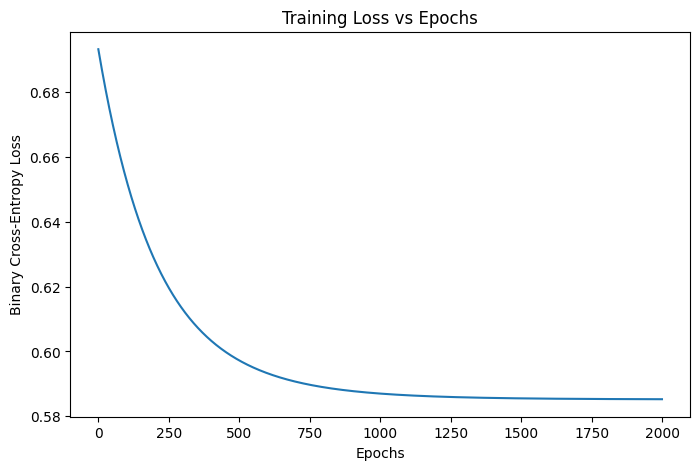

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lr_scratch.losses)

plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss vs Epochs")

plt.show()

**LR USING LIBRARY**

In [18]:
from sklearn.linear_model import LogisticRegression

lr_lib = LogisticRegression(max_iter=2000)

lr_lib.fit(X_train, y_train)

y_pred_lib = lr_lib.predict(X_test)

acc_lib = accuracy_score(y_test, y_pred_lib)
f1_lib = f1_score(y_test, y_pred_lib)

acc_lib, f1_lib

(0.718423859221452, 0.021314622360495136)

In [19]:
# comparision

In [20]:
results_lr = pd.DataFrame({
    "Model": ["Logistic Regression (Scratch)", "Logistic Regression (Library)"],
    "Accuracy": [acc_scratch, acc_lib],
    "F1 Score": [f1_scratch, f1_lib]
})

results_lr

,Model,Accuracy,F1 Score
0,Logistic Regression (Scratch),0.718272,0.019747
1,Logistic Regression (Library),0.718424,0.021315


**FINAL REMARKS**
with 2 features,
when i used rating>=5 as completed, it gave me a good f1 score. but when using rating>=7, f1 score was around 0.

with 4 features, again same observation
